# Data Loading

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [2]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text Preprocessing

In [7]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [8]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

# Time Based Sorting

In [11]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
scores = final['Score']

# Split the Data Set into train and test

In [13]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
import warnings
# =============================================================================================z

warnings.filterwarnings("ignore") 
# split the data set into train and test
X_tr, X_test, y_tr, y_test = cross_validation.train_test_split(final['Text'].values, scores, test_size=0.3, random_state=0)

y_test = y_test.values
y_tr = y_tr.values

#sampling data
train_indices = np.random.choice(len(X_tr),70000,replace=False)
test_indices = np.random.choice(len(X_test),30000,replace=False)
X_tr = X_tr[train_indices]
y_tr = y_tr[train_indices]
X_test = X_test[test_indices]
y_test = y_test[test_indices]


#Converting text to vector(BOW)
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_tr)
X_tr_vector = count_vect.transform(X_tr)
X_test_vector = count_vect.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Column Standardization

In [14]:
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(X_tr_vector)
X_tr_vector = scaler.transform(X_tr_vector)
X_test_vector =scaler.transform(X_test_vector)

# Finding Optimal Lamda using GridSearchCV

In [15]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(X_tr_vector, y_tr)

print(model.best_estimator_)
print(model.score(X_test_vector, y_test))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9020666666666667


# l2 regularizer with Optimal C

             precision    recall  f1-score   support

   negative       0.70      0.65      0.67      4697
   positive       0.94      0.95      0.94     25303

avg / total       0.90      0.90      0.90     30000

Coefficient of each feature: [[-9.41592022e-02 -1.03160492e-02  2.39873414e-05 ... -1.18626779e-05
   2.17030817e-04  1.95840613e-03]]
Training accuracy: 0.9945714285714286
Test accuracy: 0.9020666666666667


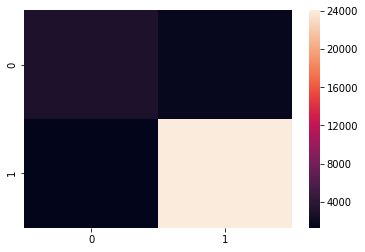

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.01,penalty='l2')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
pre_weights =classifier.coef_
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

# l1 regularizer with Optimal C

             precision    recall  f1-score   support

   negative       0.82      0.59      0.69      4697
   positive       0.93      0.98      0.95     25303

avg / total       0.91      0.92      0.91     30000

Coefficient of each feature: [[-0.06083012  0.          0.         ...  0.          0.
   0.        ]]
Training accuracy: 0.9518
Test accuracy: 0.916


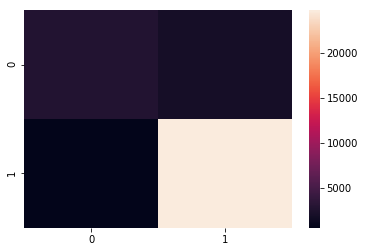

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.01,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
pre_weights =classifier.coef_
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

# Finding Optimal Lamda using RandomSearchCV

In [18]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

warnings.filterwarnings("ignore")
tuned_parameters = {"C": stats.uniform(10**-4, 10**4)}
#Using RandomsSearchCV
model = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(X_tr_vector, y_tr)

print(model.best_estimator_)
print(model.score(X_test_vector, y_test))

LogisticRegression(C=1397.6732812341104, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8834


# l2 Regularizer with Optimal C

             precision    recall  f1-score   support

   negative       0.62      0.65      0.63      4697
   positive       0.93      0.93      0.93     25303

avg / total       0.89      0.88      0.88     30000

Coefficient of each feature: [[-0.1568544  -0.03645294 -0.0009506  ... -0.00505665  0.00244679
   0.00348764]]
Training accuracy: 0.9995142857142857
Test accuracy: 0.8834


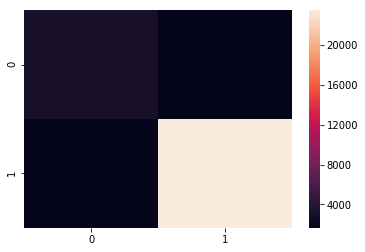

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=1397.6732812341104,penalty='l2')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
pre_weights =classifier.coef_
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

# l1 Regularizer with Optimal C

             precision    recall  f1-score   support

   negative       0.53      0.60      0.56      4697
   positive       0.92      0.90      0.91     25303

avg / total       0.86      0.85      0.86     30000

Coefficient of each feature: [[-0.26927122 -0.2815772   0.         ... -0.01142949  0.
   0.002393  ]]
Training accuracy: 1.0
Test accuracy: 0.8526


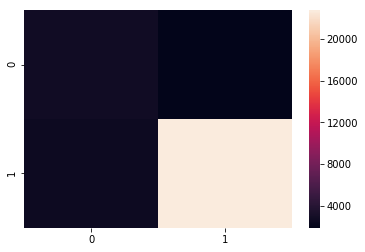

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=1397.6732812341104,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      4697
   positive       0.84      1.00      0.92     25303

avg / total       0.71      0.84      0.77     30000

Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 0.8437714285714286
Test accuracy: 0.8434333333333334
No of Non-zero elements: 0


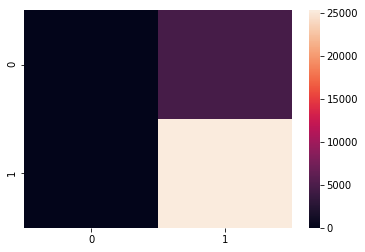

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
C_values = []
non_zero_values = []
test_accuracy =[]
classifier = LogisticRegression(C=0.0001,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.0001)

             precision    recall  f1-score   support

   negative       0.85      0.18      0.30      4697
   positive       0.87      0.99      0.93     25303

avg / total       0.87      0.87      0.83     30000

Coefficient of each feature: [[0. 0. 0. ... 0. 0. 0.]]
Training accuracy: 0.8702
Test accuracy: 0.8674
No of Non-zero elements: 85


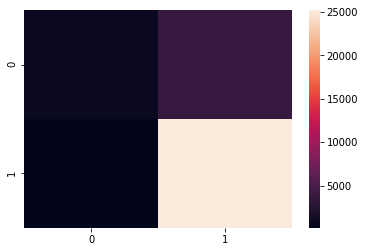

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.001,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.001)

             precision    recall  f1-score   support

   negative       0.82      0.59      0.69      4697
   positive       0.93      0.98      0.95     25303

avg / total       0.91      0.92      0.91     30000

Coefficient of each feature: [[-0.06083557  0.          0.         ...  0.          0.
   0.        ]]
Training accuracy: 0.9518
Test accuracy: 0.916
No of Non-zero elements: 4655


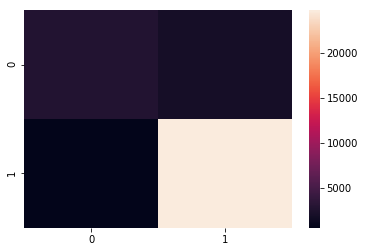

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.01,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.01)

             precision    recall  f1-score   support

   negative       0.74      0.68      0.71      4697
   positive       0.94      0.95      0.95     25303

avg / total       0.91      0.91      0.91     30000

Coefficient of each feature: [[-0.10526919  0.          0.         ...  0.          0.
   0.00042518]]
Training accuracy: 0.9905142857142857
Test accuracy: 0.9123333333333333
No of Non-zero elements: 12179


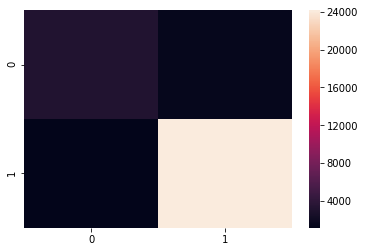

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.1,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(0.1)

             precision    recall  f1-score   support

   negative       0.65      0.67      0.66      4697
   positive       0.94      0.93      0.94     25303

avg / total       0.89      0.89      0.89     30000

Coefficient of each feature: [[-0.1392241   0.          0.         ...  0.          0.
   0.00148801]]
Training accuracy: 0.9991571428571429
Test accuracy: 0.8924333333333333
No of Non-zero elements: 14078


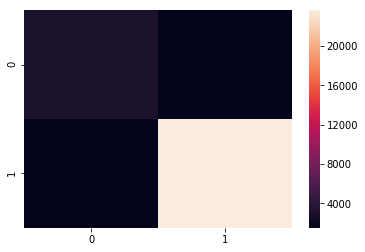

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=1,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(1)

             precision    recall  f1-score   support

   negative       0.61      0.65      0.63      4697
   positive       0.93      0.92      0.93     25303

avg / total       0.88      0.88      0.88     30000

Coefficient of each feature: [[-0.2495171   0.          0.         ...  0.          0.
   0.00070137]]
Training accuracy: 1.0
Test accuracy: 0.8792333333333333
No of Non-zero elements: 15219


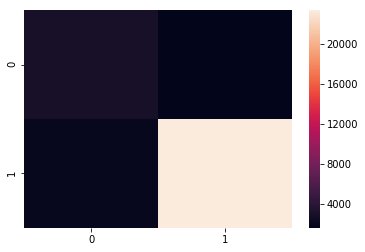

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=10,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(10)

             precision    recall  f1-score   support

   negative       0.57      0.63      0.60      4697
   positive       0.93      0.91      0.92     25303

avg / total       0.87      0.87      0.87     30000

Coefficient of each feature: [[-0.29179609 -0.01125762  0.         ...  0.          0.
   0.        ]]
Training accuracy: 1.0
Test accuracy: 0.8673666666666666
No of Non-zero elements: 19079


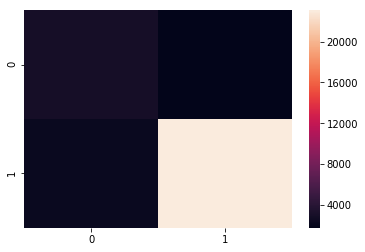

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=100,penalty='l1')
classifier.fit(X_tr_vector, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_tr_vector, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))
test_accuracy.append(classifier.score(X_test_vector, y_test))
w = classifier.coef_
non_zero_elements = np.count_nonzero(w)
print('No of Non-zero elements:',non_zero_elements)
non_zero_values.append(non_zero_elements)
C_values.append(100)

# C vs Sparsity

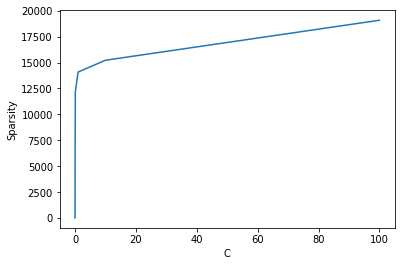

In [28]:
plt.plot(C_values, non_zero_values)
plt.xlabel('C')
plt.ylabel('Sparsity')
plt.show()

# C vs Test Accuracy

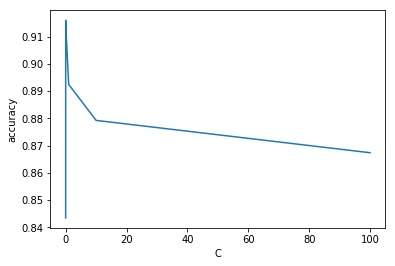

In [29]:
plt.plot(C_values, test_accuracy)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.show()

# Checking Multicollinearity

In [30]:
#adding epsilon to train data for multicollinearity check
import scipy.stats
X_train = X_tr_vector.copy()
X_train.todense()
print(scipy.stats.norm.rvs(loc=0, scale=0.01))
X_train.data += scipy.stats.norm.rvs(loc=0, scale=0.01)

-0.0017567051926290365


             precision    recall  f1-score   support

   negative       0.85      0.48      0.61      4697
   positive       0.91      0.98      0.95     25303

avg / total       0.90      0.91      0.89     30000

Coefficient of each feature: [[-2.29079839e-02 -4.13221977e-03  6.55761799e-04 ...  1.85544995e-07
   1.04850905e-03  8.74579290e-04]]
Training accuracy: 0.9597857142857142
Test accuracy: 0.9054666666666666


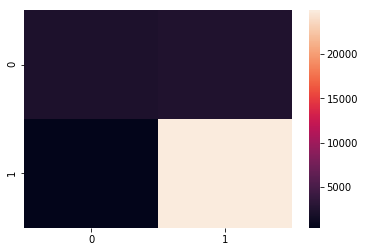

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
classifier = LogisticRegression(C=0.0001,penalty='l2')
classifier.fit(X_train, y_tr)
y_pred = classifier.predict(X_test_vector)
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix)
print(classification_report(y_test, y_pred))
post_weights = classifier.coef_
print('Coefficient of each feature:', classifier.coef_)
print('Training accuracy:', classifier.score(X_train, y_tr))
print('Test accuracy:', classifier.score(X_test_vector, y_test))

In [32]:
pre_weights

array([[-0.1568544 , -0.03645294, -0.0009506 , ..., -0.00505665,
         0.00244679,  0.00348764]])

In [33]:
post_weights

array([[-2.29079839e-02, -4.13221977e-03,  6.55761799e-04, ...,
         1.85544995e-07,  1.04850905e-03,  8.74579290e-04]])

In [34]:
difference =[]
for i in post_weights:
    difference.append(np.abs(pre_weights-post_weights))

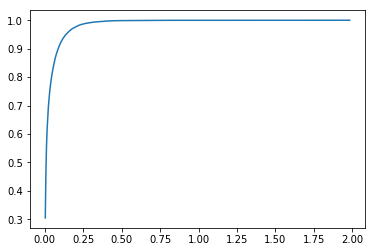

In [35]:
counts, bin_edges = np.histogram(difference, bins=500, density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)

# Most Important Features

In [36]:
def important_features(vectorizer,classifier,n=20):
    feature_names =vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[0], feature_names),reverse=True)[:n]
    print("Important words in reviews")
    for coef, feat in topn:
        print(coef, feat)
clf = LogisticRegression(C=0.0001,penalty='l2')
clf.fit(X_tr_vector, y_tr)
important_features(count_vect,clf)

Important words in reviews
0.1896819267483305 great
0.1271345853461609 love
0.12289105135782658 best
0.11066343900348279 good
0.1062581377386342 delicious
0.08274288753535143 perfect
0.08208813737651653 loves
0.07812554483789387 excellent
0.07697117371050771 is
0.0727555320545539 nice
0.07113744483347002 wonderful
0.07036076329245408 favorite
0.06961380707126823 my
0.06829997784341005 and
0.06440080745311896 highly
0.06405589587216608 easy
0.060076538231934144 tasty
0.0573498515682703 find
0.056836555411040254 this
0.0567110141374101 for


# Conclusion

In [1]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['CV Method', 'Optimal C','regularizer','Train Error','Test Error']
t.add_row(["GridSearchCV","0.01","l2","0.00542857142","0.09793333333"])
t.add_row(["GridSearchCV","0.01","l1","0.0482","0.084"])
t.add_row(["RandomSearchCV","1397.6732812341104","l2","0.00048571428","0.1166"])
t.add_row(["RandomSearchCV","1397.6732812341104","l1","0","0.1474"])
print(t)
print("**C Vs Sparsity with l1 regularizer**")
t1 = PrettyTable()
t1.field_names = ['C', 'Sparsity']
t1.add_row(["0.0001","0"])
t1.add_row(["0.001","85"])
t1.add_row(["0.01","4655"])
t1.add_row(["0.1","12179"])
t1.add_row(["1","14078"])
t1.add_row(["10","15219"])
t1.add_row(["100","19079"])
print(t1)
print("->Features are not multicollnear hence |wj| can be taken for Feature Importance.")


+----------------+--------------------+-------------+---------------+---------------+
|   CV Method    |     Optimal C      | regularizer |  Train Error  |   Test Error  |
+----------------+--------------------+-------------+---------------+---------------+
|  GridSearchCV  |        0.01        |      l2     | 0.00542857142 | 0.09793333333 |
|  GridSearchCV  |        0.01        |      l1     |     0.0482    |     0.084     |
| RandomSearchCV | 1397.6732812341104 |      l2     | 0.00048571428 |     0.1166    |
| RandomSearchCV | 1397.6732812341104 |      l1     |       0       |     0.1474    |
+----------------+--------------------+-------------+---------------+---------------+
**C Vs Sparsity with l1 regularizer**
+--------+----------+
|   C    | Sparsity |
+--------+----------+
| 0.0001 |    0     |
| 0.001  |    85    |
|  0.01  |   4655   |
|  0.1   |  12179   |
|   1    |  14078   |
|   10   |  15219   |
|  100   |  19079   |
+--------+----------+
->Features are not multicollnear